# EOPF Core Python Module Demo: Release 1 - Sprint 2

In [1]:
import os
import shutil
import numpy as np
import xarray
import zarr
from eopf.product.core import EOGroup, EOProduct, EOVariable
from eopf.product.conveniences import init_product
from eopf.product.store import EOZarrStore, EOHDF5Store, NetCDFStore
from eopf.product.store.safe import EOSafeStore
from eopf.product.store.mapping_factory import MappingFactory
from glob import glob


## output directory

In [2]:
input_folder = "./data"
output_folder="output"
output_filename="product_demo_sprint1.zarr"
try:
    os.mkdir(output_folder)
except FileExistsError:
    pass
try:
    shutil.rmtree(f"{output_folder}/{output_filename}")
except FileNotFoundError:
    pass

## Create data for eovariable

In [3]:
data_a = np.array([1,1])
data_b = np.array([2])
data_c = xarray.DataArray([[3],[3]], dims=["time", "space"])
data_d = np.array([[4.1],[4.2],[4.3]])
data_e = xarray.DataArray(np.zeros(10), dims=["dim_group/dim_10"]) 

data_coord_time = np.array([1])
data_coord_space = [2]
data_coord_dim_10 = xarray.DataArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## How to create and manipulate an EOProduct

In [4]:
product_empty = EOProduct("product_empty ")
product_empty

[EOProduct]0x16bdf6c70

In [5]:
product_empty.is_valid()

False

### Mandatory Groups

In [6]:
product_empty.add_group("measurements")
product_empty.add_group("coordinates")
product_empty.is_valid()

True

### Create a valid product

In [7]:
product: EOProduct = init_product("product_written")

In [8]:
product.is_valid()

True

### Adding groups and variables then access them

#### create groups

In [9]:
product.add_group("group0")
product.add_group("measurements/group1", coords={"time": data_coord_time}, dims=["time", "space"])
product.add_group("measurements/group1/group2/group3") # We create both group2 and group3
product["measurements"].add_group("group1/group2b") 
product.measurements.group1.group2.assign_dims(["dim_group/dim_10"])
product.measurements["group1"].add_group("/measurements/group1/group2b/group3")

[EOGroup]0x16be34760

#### create variables

In [10]:
product.measurements["group1"].add_variable("variable_a", data=data_a)
product["measurements/group1"].add_variable("group2/variable_b", data=data_b)
product["measurements/group1"]["group2"].add_variable("/measurements/group1/group2/variable_c", data=data_c, dims=data_c.dims)
product.add_variable("measurements/group1/group2c/variable_d", dims=["c1"], data=data_d) # We create both group2c and variable_d.
product["measurements/group1"]["group2"]["variable_e"] = EOVariable(data=data_e)
try:
    product["measurements/group1"]["non_existing_group/variable_e"]= EOVariable()
except KeyError:
    print("EOContainer[\"path\"] = EOObject doesn't support adding variable to non existing group with __add_item__.")


EOContainer["path"] = EOObject doesn't support adding variable to non existing group with __add_item__.


#### Access groups and variables from product or group

In [11]:
print(product["measurements/group1/group2"])
print(product["measurements"]["group1/group2"])
print(product.measurements.group1["group2"])

print(product["measurements/group1/group2/variable_b"])
print(product["measurements"]["group1/group2/variable_b"])
print(product.measurements.group1["group2/variable_b"])

# with absolute path:
group2 = product.measurements.group1.group2
print(group2["/measurements/group1"])

[EOGroup]0x16be361c0
[EOGroup]0x16be361c0
[EOGroup]0x16be361c0
[EOProduct]0x16be34af0 -> /->measurements->group1->group2 -> variable_b
[EOProduct]0x16be34af0 -> /->measurements->group1->group2 -> variable_b
[EOProduct]0x16be34af0 -> /->measurements->group1->group2 -> variable_b
[EOGroup]0x16be362b0


#### Coordinates

In [12]:
product["coordinates/space"] = EOVariable(data=data_coord_space)
product.coordinates.add_variable("dim_group/dim_10",data=data_coord_dim_10)
print(product.measurements.group1.coordinates)

{'time': [EOProduct]0x16be34af0 -> /->coordinates -> time, 'space': [EOProduct]0x16be34af0 -> /->coordinates -> space}


#### Attributes

In [13]:
product.attrs["33"]=4.2
product.attrs["test_key"]="test_value"
print("product: ", product.attrs)

product["measurements/group1/group2"].attrs["33"]=4.3
product["measurements/group1/group2"].attrs["test_key"]="test_value"
print("group: ", product["measurements/group1/group2"].attrs)

product["measurements/group1/group2/variable_b"].attrs["33"]=4.3
product["measurements/group1/group2/variable_b"].attrs["test_key"]="test_value"
print("variable: ", product["measurements/group1/group2/variable_b"].attrs)

product:  {'33': 4.2, 'test_key': 'test_value'}
group:  {'_EOPF_DIMENSIONS': ['dim_group/dim_10'], '33': 4.3, 'test_key': 'test_value'}
variable:  {'_EOPF_DIMENSIONS': ['dim_0'], '33': 4.3, 'test_key': 'test_value'}


## Visualize the product in jupyter context

In [14]:
product

[EOProduct]0x16be34af0

## Writting a product

In [15]:
output_folder

'output'

In [16]:
output_filename

'product_demo_sprint1.zarr'

In [17]:
with product.open(mode="w", store_or_path_url=EOZarrStore(f"{output_folder}/{output_filename}")):
    product.write()

## Reading a product

In [18]:
def write_zarr_file():
    file_name = "file://output/eoproduct_zarr_file.zarr"
    dims = "_EOPF_DIMENSIONS"

    root = zarr.open(file_name, mode="w")
    root.attrs["top_level"] = True
    root.create_group("coordinates")

    root["coordinates"].attrs["description"] = "coordinates Data Group"
    root["coordinates"].create_group("grid")
    root["coordinates"].create_group("tie_point")
    xarray.Dataset({"radiance": ["rows", "columns"], "orphan": ["depths", "length"]}).to_zarr(
        store=f"{file_name}/coordinates/grid",
        mode="a",
    )
    xarray.Dataset({"radiance": ["rows", "columns"], "orphan": ["depths", "length"]}).to_zarr(
        store=f"{file_name}/coordinates/tie_point",
        mode="a",
    )

    root.create_group("measurements")
    root["measurements"].attrs["description"] = "measurements Data Group"
    root["measurements"].create_group("geo_position")
    root["measurements"]["geo_position"].create_group("altitude")
    root["measurements"]["geo_position"].create_group("latitude")
    root["measurements"]["geo_position"].create_group("longitude")

    xarray.Dataset(
        {
            "polar": xarray.DataArray([[12, 4], [3, 8]], attrs={dims: ["grid/radiance"]}),
            "cartesian": xarray.DataArray([[5, -3], [-55, 66]], attrs={dims: ["tie_point/orphan"]}),
        },
    ).to_zarr(store=f"{file_name}/measurements/geo_position/altitude", mode="a")
    xarray.Dataset(
        {
            "polar": xarray.DataArray([[1, 2], [3, 4]], attrs={dims: ["grid/radiance"]}),
            "cartesian": xarray.DataArray([[9, 7], [-12, 81]], attrs={dims: ["tie_point/orphan"]}),
        },
    ).to_zarr(store=f"{file_name}/measurements/geo_position/latitude", mode="a")
    xarray.Dataset(
        {
            "polar": xarray.DataArray([[6, 7], [2, 1]], attrs={dims: ["tie_point/radiance"]}),
            "cartesian": xarray.DataArray([[25, 0], [-5, 72]], attrs={dims: ["grid/orphan"]}),
        },
    ).to_zarr(store=f"{file_name}/measurements/geo_position/longitude", mode="a")
    return file_name

In [19]:
file_name = write_zarr_file()
file_name

'file://output/eoproduct_zarr_file.zarr'

### Loading data with a store

In [20]:
product_r: EOProduct = EOProduct("product_read", store_or_path_url=EOZarrStore(file_name))
product_r

/Users/becheru/wrk/dpr/gitlab/eopf-cpm/eopf/product/core/eo_container.py:135: UserWarning: `in` statement can't check store
  warnings.warn("`in` statement can't check store")
/Users/becheru/wrk/dpr/gitlab/eopf-cpm/eopf/product/core/eo_container.py:67: UserWarning: `for in` statement can't check store
  warnings.warn("`for in` statement can't check store")


[EOProduct]0x16c465e20

In [21]:
product_r: EOProduct = EOProduct("product_read", store_or_path_url=EOZarrStore(file_name))
with product_r.open(mode="r"):
    product_r.load()
product_r

/Users/becheru/wrk/dpr/gitlab/eopf-cpm/eopf/product/core/eo_container.py:87: UserWarning: store close, it will be ignore
  warnings.warn("store close, it will be ignore")


[EOProduct]0x16c47cac0

In [22]:
print(product_r["measurements/geo_position/altitude/cartesian"]._data)
print(product_r["measurements/geo_position/altitude/polar"]._data.to_numpy())
print(product_r["measurements/geo_position/longitude/cartesian"]._data)
print(product_r["measurements/geo_position/longitude/polar"]._data.to_numpy())
print(product_r["measurements/geo_position/latitude/cartesian"]._data)
print(product_r["measurements/geo_position/latitude/polar"]._data.to_numpy())

<xarray.DataArray '' (dim_0: 2, dim_1: 2)>
array([[  5,  -3],
       [-55,  66]])
Dimensions without coordinates: dim_0, dim_1
Attributes:
    _ARRAY_DIMENSIONS:  ['dim_0', 'dim_1']
    _EOPF_DIMENSIONS:   ['tie_point/orphan']
[[12  4]
 [ 3  8]]
<xarray.DataArray '' (dim_0: 2, dim_1: 2)>
array([[25,  0],
       [-5, 72]])
Dimensions without coordinates: dim_0, dim_1
Attributes:
    _ARRAY_DIMENSIONS:  ['dim_0', 'dim_1']
    _EOPF_DIMENSIONS:   ['grid/orphan']
[[6 7]
 [2 1]]
<xarray.DataArray '' (dim_0: 2, dim_1: 2)>
array([[  9,   7],
       [-12,  81]])
Dimensions without coordinates: dim_0, dim_1
Attributes:
    _ARRAY_DIMENSIONS:  ['dim_0', 'dim_1']
    _EOPF_DIMENSIONS:   ['tie_point/orphan']
[[1 2]
 [3 4]]


## Access from a SafeStore

In [23]:
olci_path = glob(f"{input_folder}/S3A_OL_1*.SEN3")[0]
print(f"Found the product at {olci_path}")

Found the product at ./data/S3A_OL_1_EFR____20220116T092821_20220116T093121_20220117T134858_0179_081_036_2160_LN1_O_NT_002.SEN3


In [24]:
safe_store = EOSafeStore(olci_path)
olci_eop = EOProduct("S3A_OL_1_EFR_20220116T092821", store_or_path_url=safe_store)

In [25]:
with olci_eop.open():
    olci_eop.load()

/Users/becheru/wrk/dpr/gitlab/eopf-cpm/eopf/product/store/abstract.py:77: AlreadyOpen: 
  warnings.warn(AlreadyOpen())


### Configuration

In [26]:
import pprint
pprint.pprint(safe_store._config_mapping)

{'': [{'item_format': 'xfdumetadata',
       'short_name': 'metadata',
       'source_path': 'xfdumanifest.xml',
       'target_path': ''}],
 '/': [{'item_format': 'SafeHierarchy',
        'source_path': '/',
        'target_path': '/'}],
 '/conditions': [{'item_format': 'SafeHierarchy',
                  'source_path': '/conditions',
                  'target_path': '/conditions'}],
 '/conditions/geometry': [{'item_format': 'SafeHierarchy',
                           'source_path': '/conditions/geometry',
                           'target_path': '/conditions/geometry'}],
 '/conditions/geometry/altitude': [{'item_format': 'netcdf',
                                    'short_name': 'geometry_altitude',
                                    'source_path': 'geo_coordinates.nc:altitude',
                                    'target_path': '/conditions/geometry/altitude'}],
 '/conditions/geometry/oaa': [{'item_format': 'netcdf',
                               'short_name': 'geometry_oaa',
   

#### Display the tree hierarchy

In [27]:
olci_eop

[EOProduct]0x16bdeb520

##### In CLI

```
├── measurements
|  ├── orphans
|    └── oa01_radiance
|    └── oa04_radiance
|    └── oa08_radiance
|    └── oa02_radiance
|    └── oa15_radiance
|    └── oa18_radiance
|    └── oa20_radiance
|    └── oa05_radiance
|    └── oa17_radiance
|    └── oa07_radiance
|    └── oa10_radiance
|    └── oa11_radiance
|    └── oa14_radiance
|    └── oa13_radiance
|    └── oa06_radiance
|    └── oa16_radiance
|    └── oa03_radiance
|    └── oa19_radiance
|    └── oa12_radiance
|    └── oa09_radiance
|    └── oa21_radiance
|  ├── image
|    └── oa01_radiance
|    └── oa04_radiance
|    └── oa08_radiance
|    └── oa02_radiance
|    └── oa15_radiance
|    └── oa18_radiance
|    └── oa20_radiance
|    └── oa05_radiance
|    └── oa17_radiance
|    └── oa07_radiance
|    └── oa10_radiance
|    └── oa11_radiance
|    └── oa14_radiance
|    └── oa13_radiance
|    └── oa06_radiance
|    └── oa16_radiance
|    └── oa03_radiance
|    └── oa19_radiance
|    └── oa12_radiance
|    └── oa09_radiance
|    └── oa21_radiance
├── quality
|  ├── orphans
|    └── quality_flags
|  ├── image
|    └── quality_flags
├── conditions
|  ├── orphans
|    └── nb_removed_pixels
|    └── sza
|    └── altitude
|  ├── instrument
|    └── solar_flux
|    └── lambda0
|    └── relative_spectral_covariance
|    └── fwhm
|    └── frame_offset
|  ├── meteo
|    └── horizontal_wind
|    └── total_columnar_water_vapour
|    └── humidity
|    └── sea_level_pressure
|    └── atmospheric_temperature_profile
|    └── reference_pressure_level
|    └── total_ozone
|  ├── geometry
|    └── oza
|    └── oaa
|    └── altitude
|    └── sza
|    └── saa
├── coordinates
|  ├── orphans
|    └── detector_index
|    └── longitude
|    └── latitude
|  ├── tiepoint_grid
|    └── longitude
|    └── latitude
|  ├── image_grid
|    └── detector_index
|    └── row_time
|    └── longitude
|    └── latitude
```

#### Plotting EOvariable

In [28]:
total_columnar_water_vapour = olci_eop.conditions.meteo['total_columnar_water_vapour']

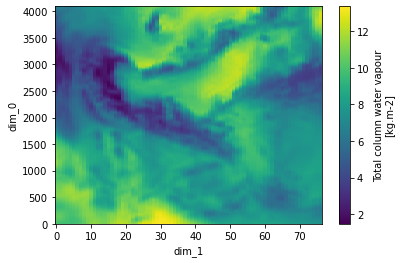

In [29]:
total_columnar_water_vapour.plot()

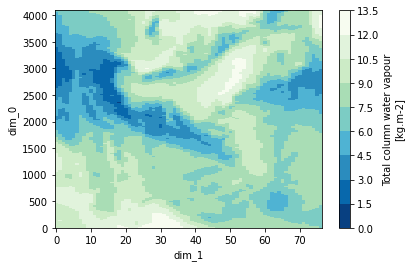

In [30]:
total_columnar_water_vapour.plot(levels=10, cmap="GnBu_r")

#### Zooming and adding external plot characteristiques

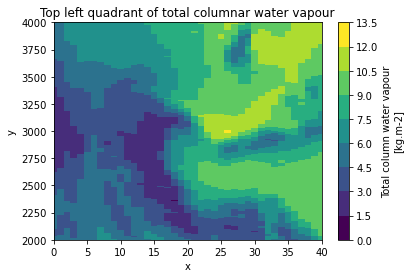

In [31]:
import matplotlib.pyplot as plt

total_columnar_water_vapour.plot(levels=10)
plt.title("Top left quadrant of total columnar water vapour")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(0, 40)
plt.ylim(2000, 4000)
plt.draw()

#### Write the product in hdf5 format

In [32]:
hdf5_path = f"{output_folder}/prod.hdf5"
hdf5_store = EOHDF5Store(hdf5_path)

In [33]:
with olci_eop.open(mode='w', store_or_path_url=hdf5_store):
    olci_eop.write()

##### Data are properly write

In [34]:
import h5py

file = h5py.File(hdf5_path, mode="r")
for group in ["orphans", "image"]:
    for i in range(1,20):
        print(file["measurements"][group][f"oa{i:02d}_radiance"])

<HDF5 dataset "oa01_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa02_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa03_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa04_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa05_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa06_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa07_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa08_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa09_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa10_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa11_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa12_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa13_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa14_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa15_radiance": shape (4091, 135), type "<f4">
<HDF5 dataset "oa16_radiance": shape (4091, 135), type "<f4">
<HDF5 da

#### Write the product in Netcdf format

In [35]:
netcdf_path = f"{output_folder}/prod.nc"
netcdf_store = NetCDFStore(netcdf_path)

In [36]:
with olci_eop.open(mode='w', store_or_path_url=netcdf_store):
    olci_eop.write()

##### Data are properly written

In [37]:
from netCDF4 import Dataset
file = Dataset(netcdf_path)
for group in ["image", "orphans"]:
    for i in range(1, 20):
        print(file["measurements"][group][f"oa{i:02d}_radiance"])

<class 'netCDF4._netCDF4.Variable'>
float32 oa01_radiance(rows, columns)
    add_offset: 0.0
    ancillary_variables: "Oa01_radiance_err"
    coordinates: "time_stamp altitude latitude longitude"
    long_name: "TOA radiance for OLCI acquisition band Oa01"
    scale_factor: 0.013946459628641605
    standard_name: "toa_upwelling_spectral_radiance"
    units: "mW.m-2.sr-1.nm-1"
    valid_max: 65534
    valid_min: 0
    _EOPF_DIMENSIONS: ["rows", "columns"]
path = /measurements/image
unlimited dimensions: 
current shape = (4091, 4865)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 oa02_radiance(rows, columns)
    add_offset: 0.0
    ancillary_variables: "Oa02_radiance_err"
    coordinates: "time_stamp altitude latitude longitude"
    long_name: "TOA radiance for OLCI acquisition band Oa02"
    scale_factor: 0.013387260027229786
    standard_name: "toa_upwelling_spectral_radiance"
    units: "mW.m-2.sr-1.nm-1"
    valid_max: 65534
 

### Mapping factory

#### Once instantiated the mapping factory detects and loads all mapping files present in eopf/product/store/mapping

In [38]:
map_factory = MappingFactory()
map_factory.mapping_set

{'/Users/becheru/wrk/dpr/gitlab/eopf-cpm/eopf/product/store/mapping/S3_OL_1_EFR_mapping.json'}

#### The get_mapping method determines if an appropiate mapping is available for a given legacy product and returns it

In [39]:
map_factory.get_mapping("data/S3A_OL_1_EFR____20220116T092821_20220116T093121_20220117T134858_0179_081_036_2160_LN1_O_NT_002.SEN3")

{'recognition': {'filename_pattern': 'S3._OL_1_E[FR]R.*SEN3',
  'product_type_pattern': 'OL_1_E[FR]R___'},
 'data_mapping': [{'short_name': 'latitude',
   'target_path': '/coordinates/image_grid/latitude',
   'source_path': 'geo_coordinates.nc:latitude',
   'item_format': 'netcdf'},
  {'short_name': 'longitude',
   'target_path': '/coordinates/image_grid/longitude',
   'source_path': 'geo_coordinates.nc:longitude',
   'item_format': 'netcdf'},
  {'short_name': 'detector_index',
   'target_path': '/coordinates/image_grid/detector_index',
   'source_path': 'instrument_data.nc:detector_index',
   'item_format': 'netcdf'},
  {'short_name': 'row_time',
   'target_path': '/coordinates/image_grid/row_time',
   'source_path': 'time_coordinates.nc:time_stamp',
   'item_format': 'netcdf'},
  {'short_name': 'tp_latitude',
   'target_path': '/coordinates/tiepoint_grid/latitude',
   'source_path': 'tie_geo_coordinates.nc:latitude',
   'item_format': 'netcdf'},
  {'short_name': 'tp_longitude',
   't

#### Other mappings can be registered via the register_mapping function, by providing it with the path to a new mapping file

In [40]:
map_factory.register_mapping("data/S3_SL_1_RBT_mapping.json")
map_factory.mapping_set

{'/Users/becheru/wrk/dpr/gitlab/eopf-cpm/eopf/product/store/mapping/S3_OL_1_EFR_mapping.json',
 'data/S3_SL_1_RBT_mapping.json'}